In [1]:
from bitarray import bitarray
import random
import numpy as np
import math

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [4]:
import pandas as pd
import sklearn.datasets as skds
from sklearn.datasets import fetch_openml

In [5]:
x, y = skds.fetch_openml("MiniBooNE", return_X_y=True)

In [6]:
x.shape

(130064, 50)

In [7]:
y.shape

(130064,)

In [8]:
np.unique(y)

array(['False', 'True'], dtype=object)

In [9]:
x = StandardScaler().fit_transform(x)


In [10]:
x_neg=x[y=='False']
x_pos=x[y=='True']

In [11]:
len(x_neg)

93565

In [12]:
len(x_pos)

36499

In [13]:
np.random.shuffle(x_neg)
x_test=x_neg[0:46782]
x_train=x_neg[46782:130064]
x_train=np.concatenate((x_train,x_pos))

In [14]:
y_train=np.concatenate((np.zeros(46783),np.ones(36499)))
y_test=np.zeros(46782)

# Kraska Model

In [15]:
class Kraska_Hash_BloomFilter:
    
    def __init__(self, size, model): #hash count is 1
        self.size = size
      #  self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)
        self.model=model #classifier model associated as hash function
        
    def add(self, num):
        #for seed in range(1,self.hash_count+1):
            #result = mmh3.hash(str(num), seed) % self.size
        result=math.floor(model.predict(num)[0]*(self.size-1))    
        self.bit_array[result] = 1
            
    def lookup(self, num):
        #for seed in range(1,self.hash_count+1):
            #result = mmh3.hash(str(num), seed) % self.size
        result=math.floor(self.model.predict(num)[0]*(self.size-1))    
        if self.bit_array[result] == 0:
                return False
        return True

    def add_init(self,x_train,y_train):
        pred = self.model.predict(x_train)
        for i in range(len(pred)):
            if(y_train[i]==1):
                result = math.floor(pred[i][0]*(self.size-1))
                self.bit_array[result] = 1

    def predict(self,x):
        initpred = self.model.predict(x)
        indexes = []
        for i in range(len(initpred)):
            indexes += [math.floor(initpred[i][0]*(self.size-1))]
        pred = []
        for i in indexes:
            pred += [self.bit_array[i]]
        return np.array(pred)

#adds ratio r of an array of random integers of size n to bloom filter bf(input : bf,size,ratio; output: data array)
def addrandom(bf,n,r):
    data=np.empty(n,dtype=int)
    for i in range(0,n):
        data[i]=random.randint(0, 100000000)
    for j in range(0,int(n*r)):
        bf.add(data[j])
    return data

#(Input:bloom filter,number array,ratio of positives; Output:(-1) for false negative, otherwise fpr)
def fpr_kraska_hash(bf,x_test,y_test):
    pred = bf.predict(x_test)
    tn, fp, fn, tp = confusion_matrix(y_test,pred,labels=[False,True]).ravel() 
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

#(Input:size of bloom filter, number of hash functions, total numbers, ratio of numbers inserted; Output: fpr)
def find_fpr(m,model,n,r):
    bf=Kraska_Hash_BloomFilter(model,m)
    data=addrandom(bf,n,r)
    return fpr(bf,data,r)

#(Input:size of bloom filter, total numbers, ratio of numbers inserted; Output: prints inputs and fpr)
def outputs(m,n,r):
    find_fpr(m,model,n,r)
    #print("For m=%d, k=%d, n=%d, r=%.3f: fpr=%.3f"%(m,k,n,r,find_fpr(m,k,n,r)))

In [16]:
def get_data_points_Kraska(x_train,y_train,x_test,y_test,init_size,diff,num,epochs,fpr_values_kraska,size_values_kraska):
    batch_size = len(x_train)
    input_dim = x_train.shape[1]
    additional_metrics = ['acc']
    loss_function = BinaryCrossentropy()
    optimizer = Adam()
    verbosity_mode = 0
    for i in range(0,num):
        layer_size = init_size + (diff*i)
        number_of_epochs = epochs
        model = Sequential()
        model.add(Dense(layer_size,input_dim=input_dim,activation='relu'))
        model.add(Dense(1,activation='sigmoid'))
        model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)
        history = model.fit(x_train, y_train, batch_size = batch_size, epochs=number_of_epochs, verbose=verbosity_mode)

        print("Number of nodes: %d" %(init_size + (diff*i)))
        plt.plot(history.history['acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.show()
        plt.plot(history.history['loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.show()

        model_size = ((input_dim+1)*layer_size + (layer_size+1))*32

        m = int(model_size/10) + 1
        net_size = model_size + m

        bf=Kraska_Hash_BloomFilter(m,model)
        bf.add_init(x_train,y_train)
        fpr = fpr_kraska_hash(bf,x_test,y_test)

        print("Size: %f bits - FPR: %f \n\n\n" % (net_size,fpr))
        fpr_values_kraska += [fpr]
        size_values_kraska += [net_size]

~~~~~~~~ Iteration 1 ~~~~~~~~ 

Number of nodes: 10


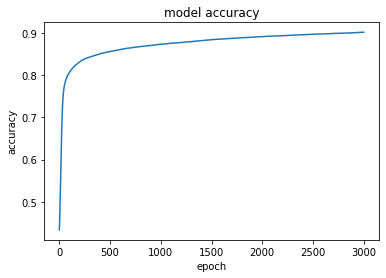

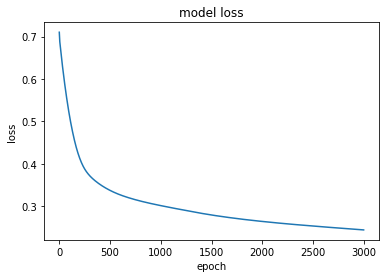

Size: 18340.000000 bits - FPR: 0.911120 



Number of nodes: 12


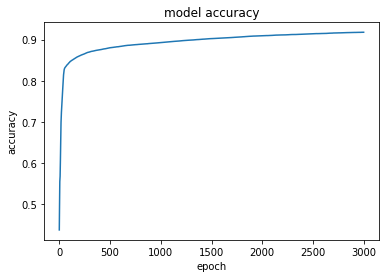

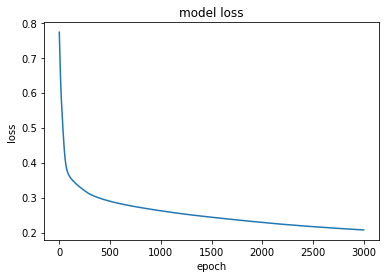

Size: 22001.000000 bits - FPR: 0.914860 



Number of nodes: 14


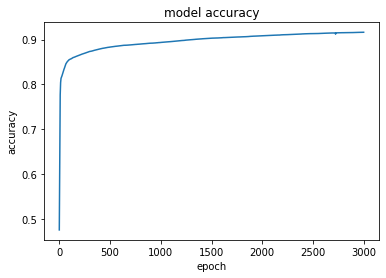

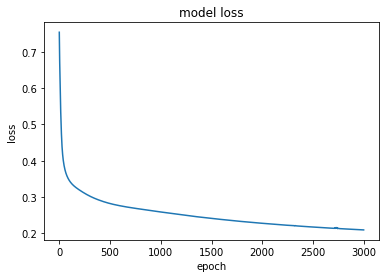

Size: 25661.000000 bits - FPR: 0.778120 



Number of nodes: 16


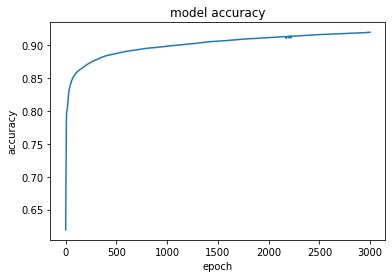

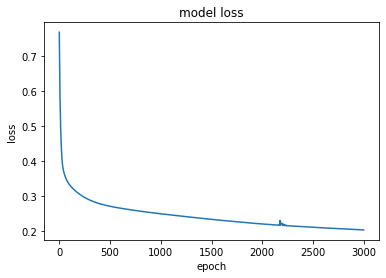

Size: 29322.000000 bits - FPR: 0.785088 



Number of nodes: 18


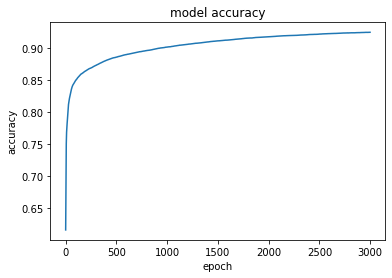

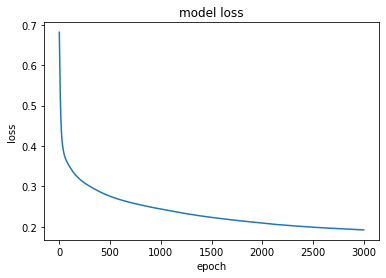

Size: 32983.000000 bits - FPR: 0.824762 



~~~~~~~~ Iteration 2 ~~~~~~~~ 

Number of nodes: 10


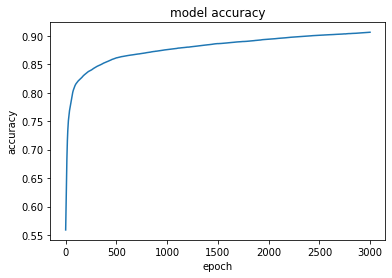

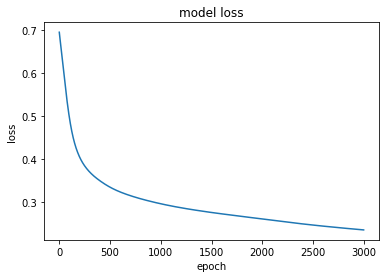

Size: 18340.000000 bits - FPR: 0.867428 



Number of nodes: 12


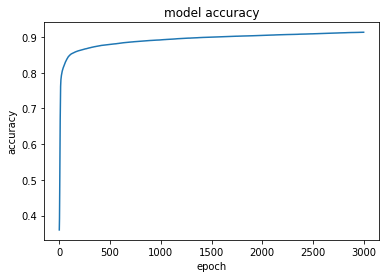

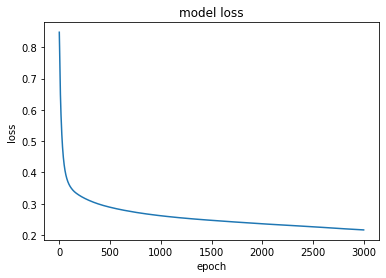

Size: 22001.000000 bits - FPR: 0.814202 



Number of nodes: 14


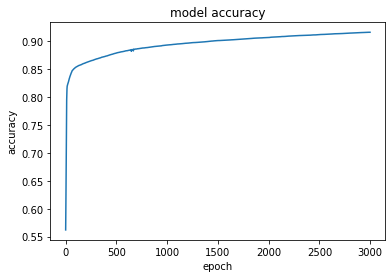

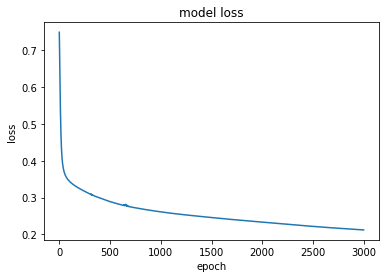

Size: 25661.000000 bits - FPR: 0.834103 



Number of nodes: 16


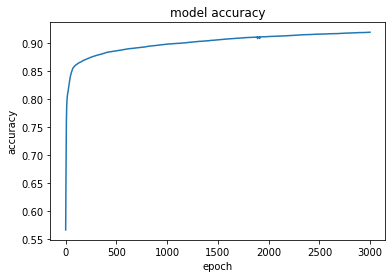

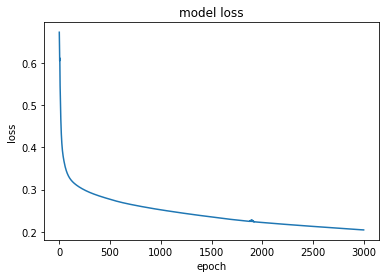

Size: 29322.000000 bits - FPR: 0.831730 



Number of nodes: 18


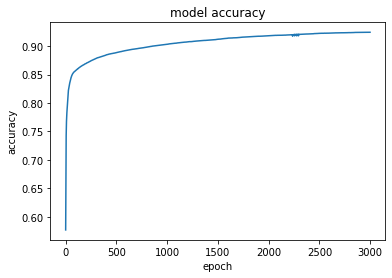

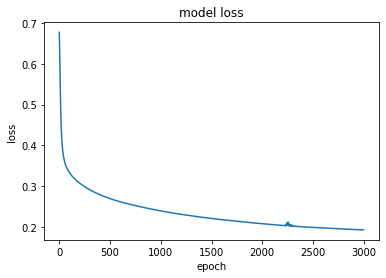

Size: 32983.000000 bits - FPR: 0.795520 



~~~~~~~~ Iteration 3 ~~~~~~~~ 

Number of nodes: 10


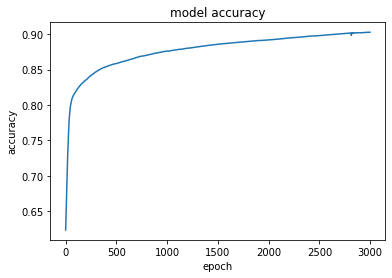

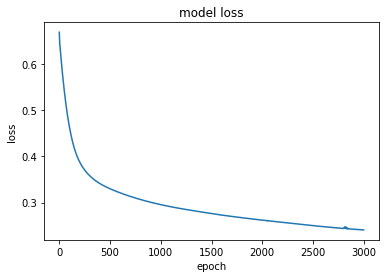

Size: 18340.000000 bits - FPR: 0.884058 



Number of nodes: 12


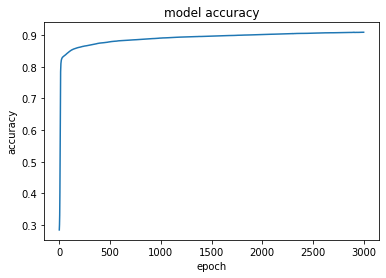

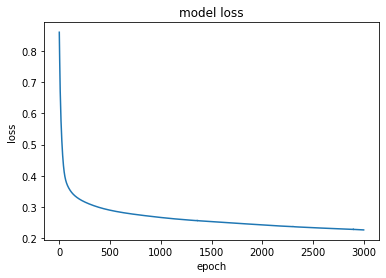

Size: 22001.000000 bits - FPR: 0.868240 



Number of nodes: 14


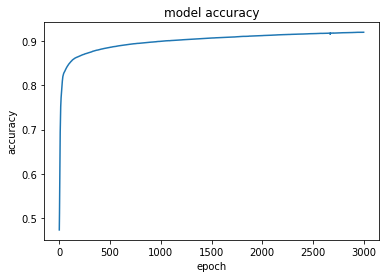

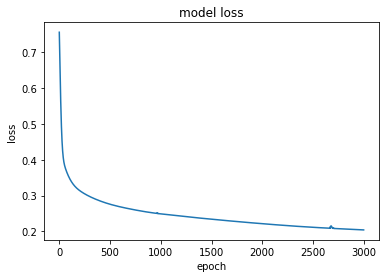

Size: 25661.000000 bits - FPR: 0.867150 



Number of nodes: 16


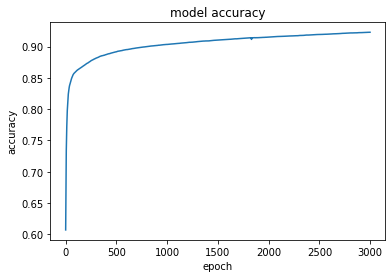

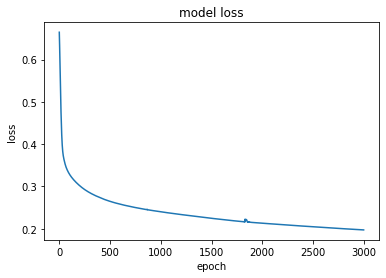

Size: 29322.000000 bits - FPR: 0.804711 



Number of nodes: 18


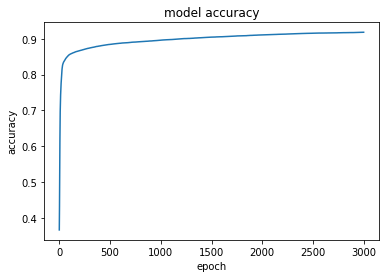

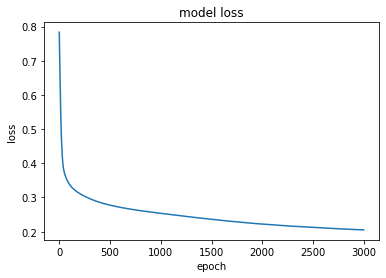

Size: 32983.000000 bits - FPR: 0.724680 





In [23]:
num_of_iterations = 3 #Increase to make graph smoother

fpr_values_kraska = []
size_values_kraska = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Kraska(x_train,y_train,x_test,y_test,10,2,5,3000,fpr_values_kraska,size_values_kraska)

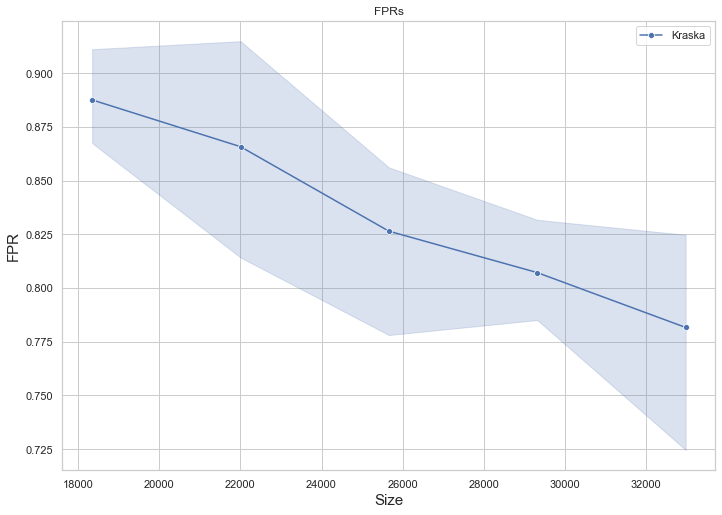

In [24]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values_kraska, y=fpr_values_kraska, err_style="band",label = "Kraska",linewidth = 1.5,marker="o")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

 # Projection Model

In [17]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1
       # print(vectors)        
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

In [18]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]
        size_values += [m]

In [27]:
num_of_iterations = 3 #Increase to make graph smoother

fpr_values = []
size_values = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,10000,3000,100,100,fpr_values,size_values)

~~~~~~~~ Iteration 1 ~~~~~~~~ 

(36499, 50)
Size: 10000 Bits - FPR: 0.938972 



Size: 13000 Bits - FPR: 0.911419 



Size: 16000 Bits - FPR: 0.921209 



Size: 19000 Bits - FPR: 0.842846 



Size: 22000 Bits - FPR: 0.819674 



Size: 25000 Bits - FPR: 0.827305 



Size: 28000 Bits - FPR: 0.821919 



Size: 31000 Bits - FPR: 0.804497 



Size: 34000 Bits - FPR: 0.685477 



Size: 37000 Bits - FPR: 0.739537 



Size: 40000 Bits - FPR: 0.741760 



Size: 43000 Bits - FPR: 0.738874 



Size: 46000 Bits - FPR: 0.723783 



Size: 49000 Bits - FPR: 0.671476 



Size: 52000 Bits - FPR: 0.662135 



Size: 55000 Bits - FPR: 0.622697 



Size: 58000 Bits - FPR: 0.676542 



Size: 61000 Bits - FPR: 0.632530 



Size: 64000 Bits - FPR: 0.594246 



Size: 67000 Bits - FPR: 0.583857 



Size: 70000 Bits - FPR: 0.551644 



Size: 73000 Bits - FPR: 0.611539 



Size: 76000 Bits - FPR: 0.576333 



Size: 79000 Bits - FPR: 0.539780 



Size: 82000 Bits - FPR: 0.492668 



Size: 85000 Bits - FPR: 0.50361

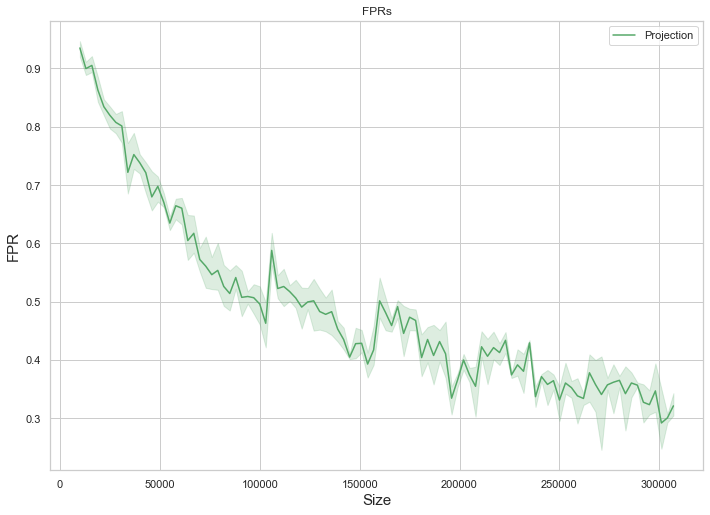

In [28]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

# Normal Bloom Filter

In [19]:
def ideal_fpr(m,n):
    k = eff_k(m,n,1)
    return (1-(1-(1/m))**(n*k))**k

In [30]:
print(sum(y_train))
print(len(y_train))

36499.0
83282


In [31]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

300
36499.0


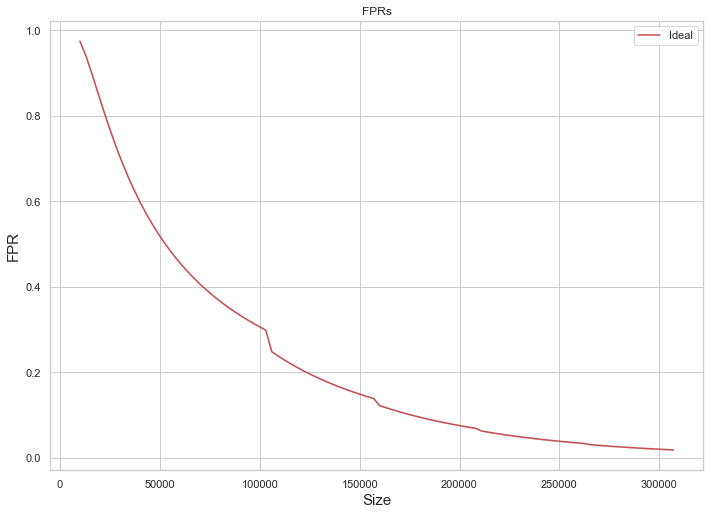

In [32]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

# FPR Comparison between Projection Model and Normal Bloom Filter

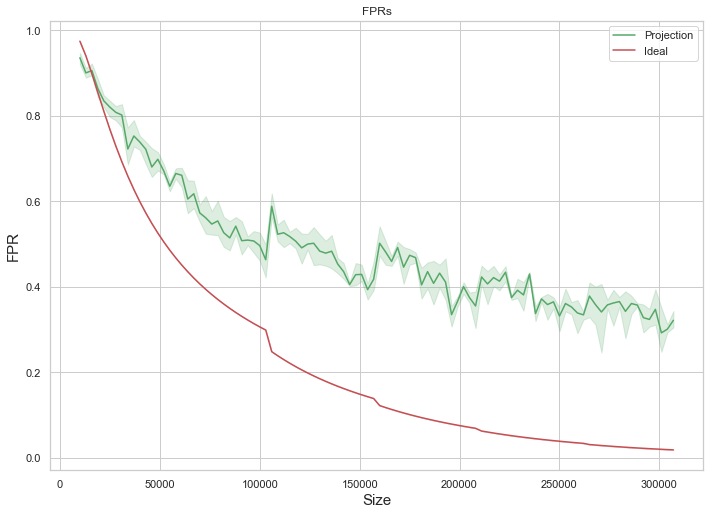

In [33]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [34]:
saved_data = list(zip(size_values, fpr_values, y_ideal))
df = pd.DataFrame(saved_data,columns = ['Size', 'Projection FPR', 'Ideal FPR'])
df.head()

,Size,Projection FPR,Ideal FPR
0,10000,0.938972,0.974011
1,13000,0.911419,0.939658
2,16000,0.921209,0.897844
3,19000,0.842846,0.853547
4,22000,0.819674,0.809687


In [35]:
df.to_csv('E:\SURA Data\MiniBooNE_Projection.csv')

# FPR Comparison between all 3 models

In [36]:
def get_data_points_Projection2(x_train,x_test,y_train,epochs,fpr_values,size_values_kraska):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in size_values_kraska:
        m = i
        k = eff_k(m,n,1)
        fpr = 1
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]

In [37]:
# Ran only once instead of thrice as size_values_kraska already has tripple length
fpr_values_projection = []
get_data_points_Projection2(x_train,x_test,y_train,100,fpr_values_projection,size_values_kraska)

(36499, 50)
Size: 18340 Bits - FPR: 0.820358 



Size: 22001 Bits - FPR: 0.866915 



Size: 25661 Bits - FPR: 0.822966 



Size: 29322 Bits - FPR: 0.775662 



Size: 32983 Bits - FPR: 0.749049 



Size: 18340 Bits - FPR: 0.875123 



Size: 22001 Bits - FPR: 0.903937 



Size: 25661 Bits - FPR: 0.743320 



Size: 29322 Bits - FPR: 0.845261 



Size: 32983 Bits - FPR: 0.815527 



Size: 18340 Bits - FPR: 0.808217 



Size: 22001 Bits - FPR: 0.819760 



Size: 25661 Bits - FPR: 0.740691 



Size: 29322 Bits - FPR: 0.846736 



Size: 32983 Bits - FPR: 0.818328 





In [38]:
n = sum(y_train)
y_ideal_k=[]
for x in size_values_kraska:
    y_ideal_k+=[float(ideal_fpr(x,n))]
print(len(y_ideal_k))
print(n)

15
36499.0


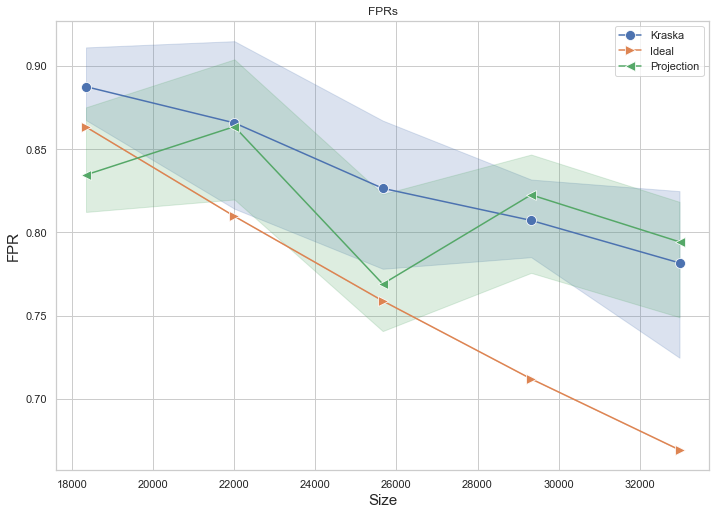

In [39]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values_kraska, y=fpr_values_kraska, err_style="band",marker="o",label = "Kraska",linestyle= "--",markersize=10)
sns.lineplot(x=size_values_kraska, y=y_ideal_k, err_style="band",marker='>',label = "Ideal",linestyle= ":",markersize = 10)
sns.lineplot(x=size_values_kraska, y=fpr_values_projection, err_style="band",marker='<',label = "Projection",linestyle= "-.",markersize = 10)
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [40]:
saved_data = list(zip(size_values_kraska, fpr_values_kraska,fpr_values_projection, y_ideal_k))
df = pd.DataFrame(saved_data,columns = ['Size','Kraska FPR', 'Projection FPR', 'Ideal FPR'])
df.head()

,Size,Kraska FPR,Projection FPR,Ideal FPR
0,18340,0.911120,0.820358,0.863330
1,22001,0.914860,0.866915,0.809672
2,25661,0.778120,0.822966,0.758861
3,29322,0.785088,0.775662,0.711998
4,32983,0.824762,0.749049,0.669324


In [41]:
df.to_csv('E:\SURA Data\MiniBooNE_Kraska_Projection.csv')

# Projection Model with only 1 Hash Function

In [42]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = 1  #Setting k as 1
        fpr = 1
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]
        size_values += [m]

In [43]:
num_of_iterations = 3 #Increase to make graph smoother

fpr_values = []
size_values = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,10000,3000,100,100,fpr_values,size_values)

~~~~~~~~ Iteration 1 ~~~~~~~~ 

(36499, 50)
Size: 10000 Bits - FPR: 0.924501 



Size: 13000 Bits - FPR: 0.874140 



Size: 16000 Bits - FPR: 0.866679 



Size: 19000 Bits - FPR: 0.878671 



Size: 22000 Bits - FPR: 0.870142 



Size: 25000 Bits - FPR: 0.848788 



Size: 28000 Bits - FPR: 0.812642 



Size: 31000 Bits - FPR: 0.791351 



Size: 34000 Bits - FPR: 0.674212 



Size: 37000 Bits - FPR: 0.722521 



Size: 40000 Bits - FPR: 0.741482 



Size: 43000 Bits - FPR: 0.742187 



Size: 46000 Bits - FPR: 0.732504 



Size: 49000 Bits - FPR: 0.687123 



Size: 52000 Bits - FPR: 0.661365 



Size: 55000 Bits - FPR: 0.596383 



Size: 58000 Bits - FPR: 0.645633 



Size: 61000 Bits - FPR: 0.590291 



Size: 64000 Bits - FPR: 0.553674 



Size: 67000 Bits - FPR: 0.592856 



Size: 70000 Bits - FPR: 0.598756 



Size: 73000 Bits - FPR: 0.571459 



Size: 76000 Bits - FPR: 0.557586 



Size: 79000 Bits - FPR: 0.467316 



Size: 82000 Bits - FPR: 0.594524 



Size: 85000 Bits - FPR: 0.55814

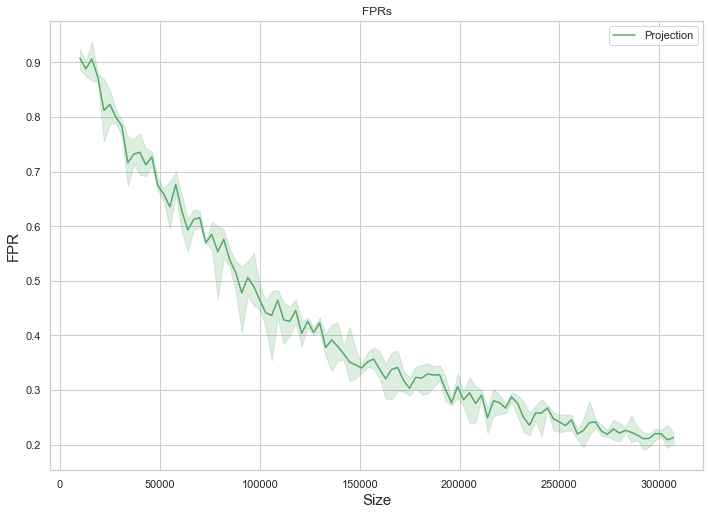

In [44]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

# Comparing new Projection Model with Ideal Bloom Filter

In [45]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

300
36499.0


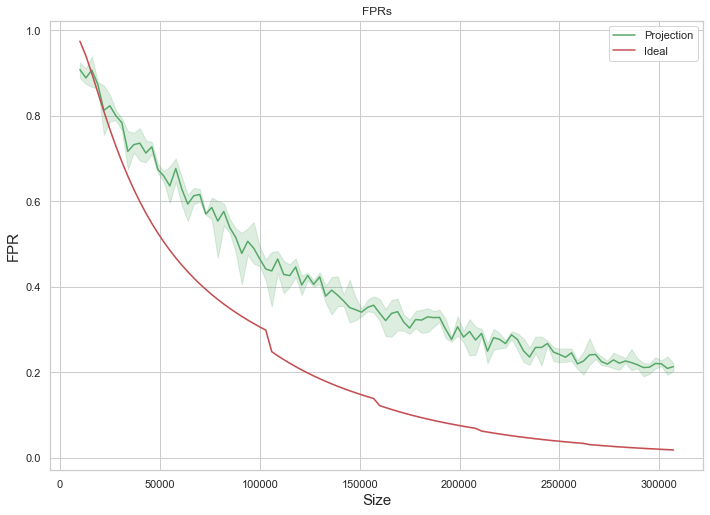

In [46]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [47]:
saved_data = list(zip(size_values, fpr_values, y_ideal))
df = pd.DataFrame(saved_data,columns = ['Size', 'Projection FPR', 'Ideal FPR'])
df.head()

,Size,Projection FPR,Ideal FPR
0,10000,0.924501,0.974011
1,13000,0.874140,0.939658
2,16000,0.866679,0.897844
3,19000,0.878671,0.853547
4,22000,0.870142,0.809687


In [48]:
df.to_csv('E:\SURA Data\MiniBooNE_Projection1Hash.csv')

# Giving independent bitarrays for each hash function in Projection Model

In [20]:
class Projection_Multiple_Array_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1    
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = (size//hash_count) # Size of each bitarray
        self.hash_count = hash_count
        arrays = []
        for i in range(0,hash_count):
            array = bitarray(size//hash_count)
            array.setall(0)
            arrays += [array]
        self.bit_arrays = arrays

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        x = [x]
        hash_values = self.give_hash_values(x)
        for i in range(0,len(hash_values)):
            for j in range(0,self.hash_count):
                self.bit_arrays[j][int(hash_values[i][j])] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in range(0,len(hash_values)):
            for j in range(0,self.hash_count):
                self.bit_arrays[j][int(hash_values[i][j])] = 1
            
    def lookup(self, x):
        x = [x]
        hash_values = self.give_hash_values(x)
        for i in range(0,len(hash_values[0])):
            for j in range(0,self.hash_count):
                if(self.bit_arrays[j][int(hash_values[i][j])] == 0):
                    return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in range(0,len(pos_hash_values)):
        for j in range(0,bf.hash_count):
            if(bf.bit_arrays[j][int(pos_hash_values[i][j])] == 0):
                return -1
    for i in range(0,len(neg_hash_values)):
        flag = 0
        for j in range(0,bf.hash_count):
            if(bf.bit_arrays[j][int(neg_hash_values[i][j])] == 0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in range(0,len(neg_hash_values)):
        flag = 0
        for j in range(0,bf.hash_count):
            if(bf.bit_arrays[j][int(neg_hash_values[i][j])] == 0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

In [21]:
def get_data_points_Projection_Multiple_Array(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        tempbf = Projection_Multiple_Array_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_Multiple_Array_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]
        size_values += [m]

In [22]:
num_of_iterations = 3 #Increase to make graph smoother

fpr_values = []
size_values = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection_Multiple_Array(x_train,x_test,y_train,10000,3000,100,100,fpr_values,size_values)

~~~~~~~~ Iteration 1 ~~~~~~~~ 

(36499, 50)
Size: 10000 Bits - FPR: 0.935296 



Size: 13000 Bits - FPR: 0.925634 



Size: 16000 Bits - FPR: 0.917148 



Size: 19000 Bits - FPR: 0.879526 



Size: 22000 Bits - FPR: 0.799987 



Size: 25000 Bits - FPR: 0.748044 



Size: 28000 Bits - FPR: 0.825488 



Size: 31000 Bits - FPR: 0.784575 



Size: 34000 Bits - FPR: 0.752811 



Size: 37000 Bits - FPR: 0.782609 



Size: 40000 Bits - FPR: 0.781818 



Size: 43000 Bits - FPR: 0.692318 



Size: 46000 Bits - FPR: 0.735090 



Size: 49000 Bits - FPR: 0.708606 



Size: 52000 Bits - FPR: 0.662990 



Size: 55000 Bits - FPR: 0.625647 



Size: 58000 Bits - FPR: 0.666859 



Size: 61000 Bits - FPR: 0.631803 



Size: 64000 Bits - FPR: 0.651319 



Size: 67000 Bits - FPR: 0.607114 



Size: 70000 Bits - FPR: 0.571694 



Size: 73000 Bits - FPR: 0.588923 



Size: 76000 Bits - FPR: 0.594267 



Size: 79000 Bits - FPR: 0.510346 



Size: 82000 Bits - FPR: 0.525993 



Size: 85000 Bits - FPR: 0.53377

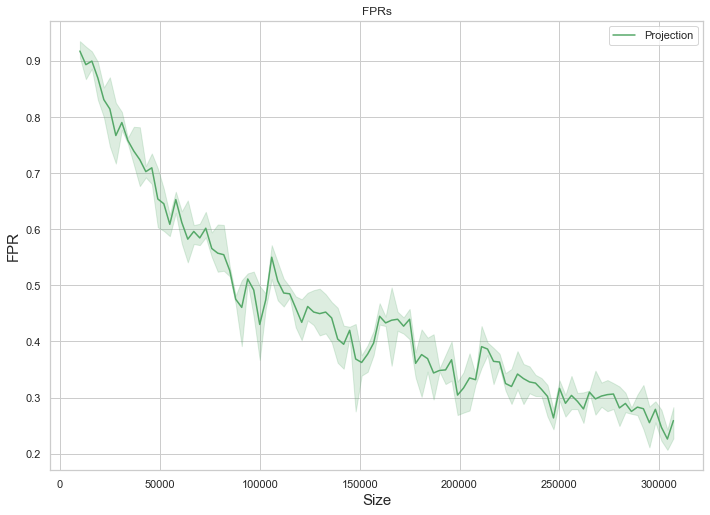

In [23]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [24]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

300
36499.0


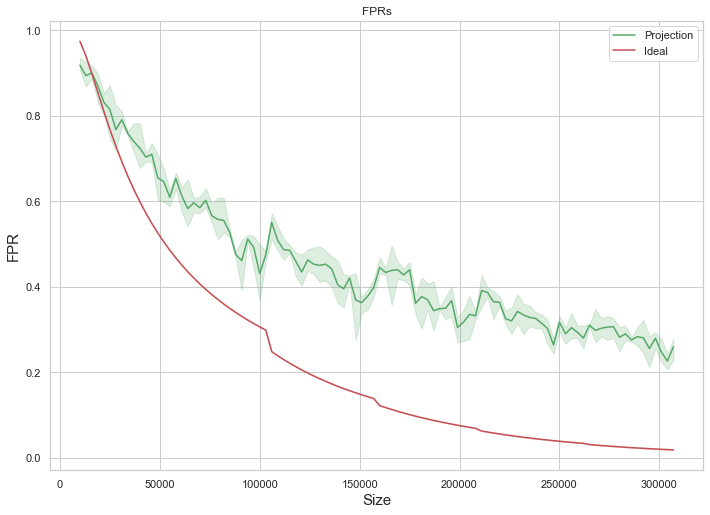

In [25]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [26]:
saved_data = list(zip(size_values, fpr_values, y_ideal))
df = pd.DataFrame(saved_data,columns = ['Size', 'Projection FPR', 'Ideal FPR'])
df.head()
df.to_csv('E:\SURA Data\MiniBooNE_ProjectionDiffBitarrays.csv')

# Projection with Non-Unit Vectors

In [27]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,5,size=(hash_count,dim)) ### Changed Standard Deviation to 5
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1
       # print(vectors)        
        self.unit_vectors = np.transpose(vectors) ### Not Unit Vectors
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

In [28]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]
        size_values += [m]

In [29]:
num_of_iterations = 3 #Increase to make graph smoother

fpr_values = []
size_values = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,10000,3000,100,100,fpr_values,size_values)

~~~~~~~~ Iteration 1 ~~~~~~~~ 

(36499, 50)
ipykernel_launcher:21: RuntimeWarning: overflow encountered in exp
Size: 10000 Bits - FPR: 0.725087 



Size: 13000 Bits - FPR: 0.632081 



Size: 16000 Bits - FPR: 0.654803 



Size: 19000 Bits - FPR: 0.686311 



Size: 22000 Bits - FPR: 0.609166 



Size: 25000 Bits - FPR: 0.472532 



Size: 28000 Bits - FPR: 0.461203 



Size: 31000 Bits - FPR: 0.591403 



Size: 34000 Bits - FPR: 0.552349 



Size: 37000 Bits - FPR: 0.549015 



Size: 40000 Bits - FPR: 0.593989 



Size: 43000 Bits - FPR: 0.520606 



Size: 46000 Bits - FPR: 0.452653 



Size: 49000 Bits - FPR: 0.432004 



Size: 52000 Bits - FPR: 0.452396 



Size: 55000 Bits - FPR: 0.472468 



Size: 58000 Bits - FPR: 0.435039 



Size: 61000 Bits - FPR: 0.420696 



Size: 64000 Bits - FPR: 0.418580 



Size: 67000 Bits - FPR: 0.441388 



Size: 70000 Bits - FPR: 0.353833 



Size: 73000 Bits - FPR: 0.410885 



Size: 76000 Bits - FPR: 0.457783 



Size: 79000 Bits - FPR: 0.364649 



S

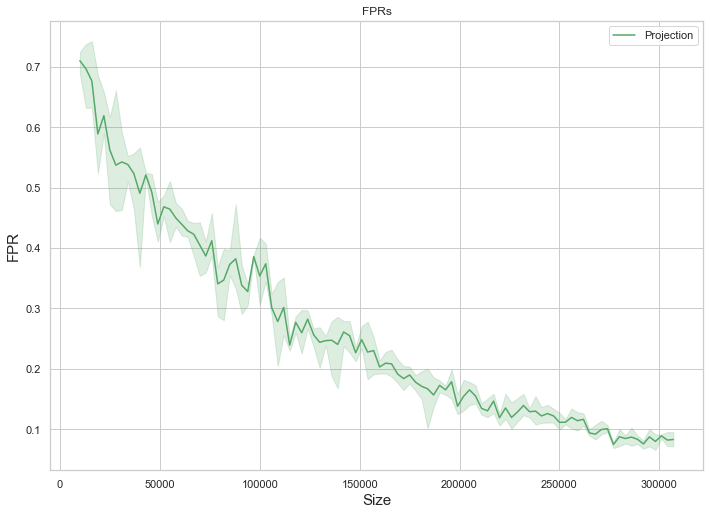

In [30]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [31]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

300
36499.0


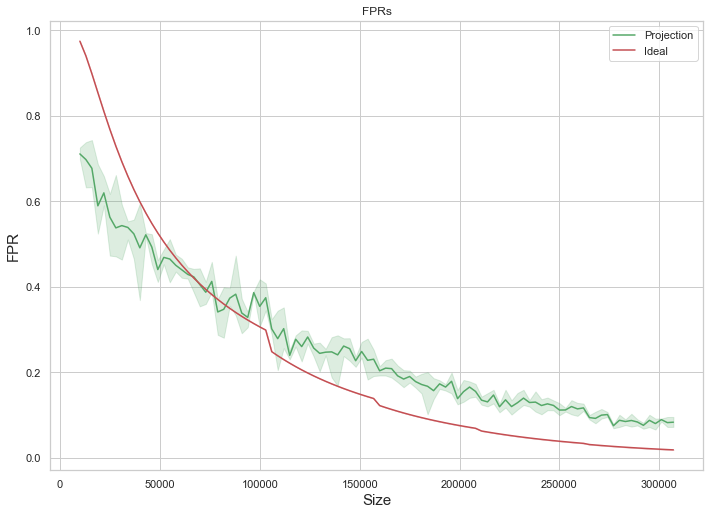

In [32]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [34]:
saved_data = list(zip(size_values, fpr_values, y_ideal))
df = pd.DataFrame(saved_data,columns = ['Size', 'Projection FPR', 'Ideal FPR'])
df.head()
df.to_csv('E:\SURA Data\MiniBooNE_non_unit_vectors_std_dev_5.csv')